                             Driver Drowsiness Detection using Deep Learning

Drowsy driving is a crucial component in the vast majority of car accidents worldwide. As a result, recognizing driver tiredness is the most important way to preventing these mishaps, which can help reduce road accidents. The goal of this project is to create a Sleepiness Detection System that can identify whether or not a driver's eyes are closed or yawning. Deep learning (CNN model) is utilized to determine if the driver's eyes are open or closed.

In [2]:
#Importing neccessary Libraries
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plot
from sklearn.preprocessing import LabelBinarizer-c
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [3]:
#Listing the directories under the dataset
data_directories = os.listdir(r"C:\Users\manik_bvty0vb\OneDrive\Desktop\Data\train")
print("Directories under the dataset", data_directories)

Directories under the dataset ['Closed', 'no_yawn', 'Open', 'yawn']


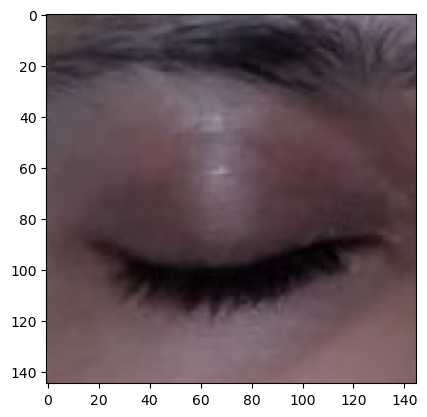

In [4]:
#showing Sample Closed eye picture from the dataset
plot.imshow(plot.imread(r"C:\Users\manik_bvty0vb\OneDrive\Desktop\Data\train\Closed\_0.jpg"))

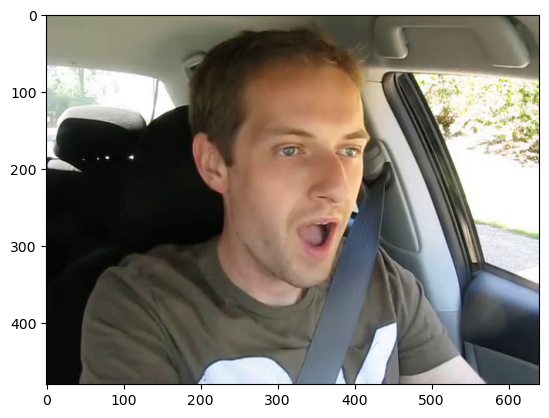

In [98]:
#showing Sample yawning picture from the dataset
plot.imshow(plot.imread(r"C:\Users\manik_bvty0vb\OneDrive\Desktop\Data\train\yawn\41.jpg"))


In [5]:
#Data Preprocessing
#Detecting face from the yawning Images
def detect_face_for_yawn_data():
    yawn_data = []
    Categories = ["yawn", "no_yawn"]
    for category in Categories:
        actual_path = os.path.join(r"C:\Users\manik_bvty0vb\OneDrive\Desktop\Data\train", category)
        class_no = Categories.index(category)
        print("category:",category, "| Class Number:", class_no)
        for image in os.listdir(actual_path):
            arr_image = cv2.imread(os.path.join(actual_path, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(r"C:\Users\manik_bvty0vb\OneDrive\Desktop\Data\haarcascade_frontalface_default.xml")
            faces = face_cascade.detectMultiScale(arr_image, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(arr_image, (x, y), (x+w, y+h), (0, 255, 0), thickness=2)
                roi_color = img[y:y+h, x:x+w]
                resize_array = cv2.resize(roi_color, (145, 145))
                yawn_data.append([resize_array, class_no])
    return yawn_data

Here in the above function we trying to detect face area from the complete picture
We are using openCV's haarcascade algorithm to detect face
Here we load Haar Cascade Classifier with cv2.CascadeClassifier and recognizes faces in the image with cv2.CascadeClassifier.detectMultiScale.
Here we also crop and resize the face region to the fixed size (145)

In [6]:
#Read Eyes Data
def get_eyes_data():
    Categories = ['Closed', 'Open']
    eyes_data = []
    for category in Categories:
        actual_path = os.path.join(r"C:\Users\manik_bvty0vb\OneDrive\Desktop\Data\train", category)
        class_no = Categories.index(category)
        class_no +=2
        print("category:",category, "| Class Number:", class_no)
        for img in os.listdir(actual_path):
            try:
                img_array = cv2.imread(os.path.join(actual_path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (145, 145))
                eyes_data.append([resized_array, class_no])
            except Exception as e:
                print(e)
    return eyes_data 

Here in the above function we are just reading eyes data using OpenCV and resizing the image to specific size

In [7]:
yawn_data = detect_face_for_yawn_data()
eyes_data = get_eyes_data()
yawn_data.extend(eyes_data)
new_data = np.array(yawn_data)

category: yawn | Class Number: 0
category: no_yawn | Class Number: 1
category: Closed | Class Number: 2
category: Open | Class Number: 3


C:\Users\manik_bvty0vb\AppData\Local\Temp\ipykernel_13304\2303133727.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_data = np.array(yawn_data)


In [9]:
#divide features and Labels
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

#LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

y = np.array(y)

new_data array, which comprises picture features and labels. It extracts the feature (the image itself) and the matching label for each element, appending the feature to the X list and the label to the y list.

'LabelBinarizer' is used to fit the encoder to the given categories labels and then transform them into binary labels. The altered labels are then saved in 'y'.

In [10]:
#Spliting testing and Training data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)
len(X_test)

385

The sklearn.model_selection module's train_test_split function is used to divide the data into training and testing sets with test set size 20%.

In [11]:
#Image Preprocessing
train_gen = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_gen = ImageDataGenerator(rescale=1/255)

train_gen = train_gen.flow(np.array(X_train), y_train, shuffle=False)
test_gen = test_gen.flow(np.array(X_test), y_test, shuffle=False)

Here we are utilizing the 'ImageDataGenerator' class from the Keras library. These generators are used for data augmentation and image preprocessing before training and testing a deep learning model

After the generators are built, the flow() method is called on both train_gen and test_gen, passing in the input data (np.array(X_train) for training data and np.array(X_test) for testing data) and the appropriate labels (y_train for training data and y_test for testing data) as arguments. This function returns a generator object that may be used to supply data and labels to a deep learning model in batches during training and testing. The shuffle=False parameter is used to maintain the order of the data and labels consistent during training and testing.


In [12]:
#Define Layer
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

Here we built a CNN by adding convolutional and max pooling layers which are repeated with 128, 64, and 32 filters, each with a ReLU activation function.

model.add(Flatten()) Flattens the output of the final convolutional layer into a 1D array.

model.add(Dropout(0.5)) employs a dropout regularization layer to prevent overfitting by randomly removing 50% of the input units during training.

model.add(Dense(64, activation="relu") adds a fully connected layer with 64 neurons and the ReLU activation function.

model.add(Dense(4, activation="softmax")) adds a last fully linked layer with 4 neurons and a softmax activation function. The softmax function returns a probability distribution over the four output classes.

We used "categorical_crossentropy" as we have to classify between four kinds and we used "adam" as optimizer

In [13]:
#Train the model
history = model.fit(train_gen, epochs=50, validation_data=test_gen, shuffle=True, validation_steps=len(test_gen))

Epoch 1/50
49/49 [==============================] - 454s 9s/step - loss: 0.9832 - accuracy: 0.5779 - val_loss: 0.6898 - val_accuracy: 0.6597
Epoch 2/50
49/49 [==============================] - 443s 9s/step - loss: 0.4555 - accuracy: 0.7987 - val_loss: 0.3208 - val_accuracy: 0.8545
Epoch 3/50
49/49 [==============================] - 432s 9s/step - loss: 0.3397 - accuracy: 0.8552 - val_loss: 0.3344 - val_accuracy: 0.8649
Epoch 4/50
49/49 [==============================] - 437s 9s/step - loss: 0.3120 - accuracy: 0.8714 - val_loss: 0.2372 - val_accuracy: 0.8883
Epoch 5/50
49/49 [==============================] - 432s 9s/step - loss: 0.2910 - accuracy: 0.8799 - val_loss: 0.2189 - val_accuracy: 0.9039
Epoch 6/50
49/49 [==============================] - 433s 9s/step - loss: 0.2874 - accuracy: 0.8805 - val_loss: 0.2366 - val_accuracy: 0.9091
Epoch 7/50
49/49 [==============================] - 445s 9s/step - loss: 0.2685 - accuracy: 0.8929 - val_loss: 0.2196 - val_accuracy: 0.9039
Epoch 8/50
49

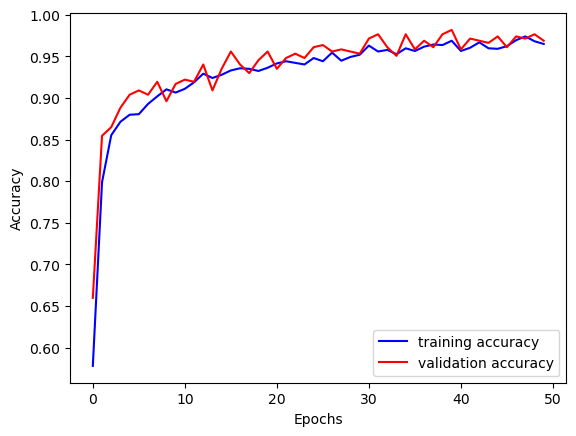

In [14]:
#Visualize the accuracy curve
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(accuracy))
plot.xlabel('Epochs')
plot.ylabel('Accuracy')

plot.plot(epochs, accuracy, "b", label="training accuracy")
plot.plot(epochs, val_accuracy, "r", label="validation accuracy")
plot.legend()
plot.show()


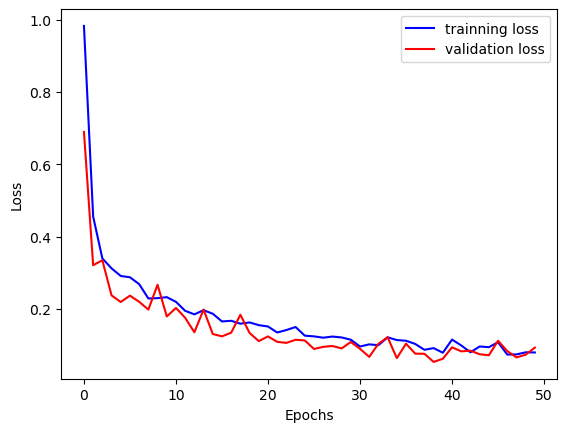

In [15]:
#Visualize the loss 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plot.xlabel('Epochs')
plot.ylabel('Loss')

plot.plot(epochs, loss, "b", label="trainning loss")
plot.plot(epochs, val_loss, "r", label="validation loss")
plot.legend()
plot.show()

In [ ]:
                                                Conclusion
Deep learning driver drowsiness detection is employing computer vision and deep learning techniques to detect indicators of tiredness in drivers. The purpose of this technique is to increase road safety by warning drivers when they are about to fall asleep behind the wheel.

We can use this model and design a system which detects the drowsiness and alerts the driver